In [6]:
# ================================
# 1. Imports & basic configuration
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from scipy.ndimage import median_filter
from scipy.signal import find_peaks

plt.style.use("default")  # keep plots clean

# Path to the Dips + Pull-ups CSV file (relative to this notebook)
DATA_PATH = Path("..") / "data" / "Dips_PU.csv"

print("Using data file:", DATA_PATH)

# ENMO smoothing parameters
MEDIAN_FILTER_SIZE = 5          # samples
MOVING_AVERAGE_WINDOW_S = 0.2   # seconds

# Dips & pull-ups repetition detection parameters
EXERCISE_PARAMS = {
    "Dips": {
        "min_interval_s": 1.3,   # dips are faster
        "percentile": 88,        # amplitude threshold (adaptive)
    },
    "Pull-ups": {
        "min_interval_s": 2.0,   # pull-ups slower
        "percentile": 85,
    },
}


Using data file: ..\data\Dips_PU.csv


In [7]:
# =======================================
# 2. Load raw accelerometer data from CSV
# =======================================

def load_acc_csv(path: str) -> pd.DataFrame:
    """
    Load accelerometer data exported from OmGui.

    Assumes CSV has no header and columns are:
        0: timestamp (string)
        1: Ax
        2: Ay
        3: Az

    Returns a DataFrame with:
        - timestamp (datetime)
        - t (seconds from start)
        - Ax, Ay, Az (float)
    """
    df = pd.read_csv(path, header=None)
    df.columns = ["timestamp", "Ax", "Ay", "Az"]

    df["timestamp"] = pd.to_datetime(df["timestamp"])
    t0 = df["timestamp"].iloc[0]
    df["t"] = (df["timestamp"] - t0).dt.total_seconds()

    return df


df_raw = load_acc_csv(DATA_PATH)

print("Number of samples:", len(df_raw))
print("Recording time span:", df_raw["timestamp"].iloc[0], "->", df_raw["timestamp"].iloc[-1])
print("Duration (s):", df_raw["t"].iloc[-1])
df_raw.head()

Number of samples: 18000
Recording time span: 2025-11-27 19:00:06.929000 -> 2025-11-27 19:03:01.720000
Duration (s): 174.791


,timestamp,Ax,Ay,Az,t
0,2025-11-27 19:00:06.929,0.031250,-1.031250,0.093750,0.000
1,2025-11-27 19:00:06.939,0.015625,-0.171875,0.546875,0.010
2,2025-11-27 19:00:06.949,0.000000,-0.078125,0.375000,0.020
3,2025-11-27 19:00:06.960,0.000000,-0.046875,0.171875,0.031
4,2025-11-27 19:00:06.969,-0.109375,-0.109375,0.046875,0.040


In [8]:
# ===================================
# 3. Estimate sampling frequency (Hz)
# ===================================

def estimate_sampling_frequency(df: pd.DataFrame) -> float:
    dts = df["timestamp"].diff().dt.total_seconds().dropna()
    fs = 1.0 / dts.mean()
    return fs


fs = estimate_sampling_frequency(df_raw)
print(f"Estimated sampling frequency: {fs:.2f} Hz")


Estimated sampling frequency: 102.97 Hz


In [9]:
# ===================================================
# 4. Define time windows for Dips and Pull-ups (s)
# ===================================================

# extract date of recording and first timestamp
date0 = df_raw["timestamp"].iloc[0].date()
t0 = df_raw["timestamp"].iloc[0]

def rel_t(h: int, m: int, s: int) -> float:
    """
    Convert absolute clock time (h:m:s) on the recording day
    into relative seconds from the beginning of the file.
    """
    dt = pd.Timestamp(year=date0.year, month=date0.month, day=date0.day,
                      hour=h, minute=m, second=s)
    return (dt - t0).total_seconds()

# ---- CORRECT WINDOWS ----
# Dips: start at 19:00:00, duration 55 s
DIPS_START_S = rel_t(19, 0, 0)
DIPS_END_S   = DIPS_START_S + 55.0

# Pull-ups: start at 19:02:00, duration 39 s
PU_START_S = rel_t(19, 2, 0)
PU_END_S   = PU_START_S + 39.0

print(f"Dips window:     {DIPS_START_S:.1f} s -> {DIPS_END_S:.1f} s "
      f"(duration {DIPS_END_S - DIPS_START_S:.1f} s)")
print(f"Pull-ups window: {PU_START_S:.1f} s -> {PU_END_S:.1f} s "
      f"(duration {PU_END_S - PU_START_S:.1f} s)")

Dips window:     -6.9 s -> 48.1 s (duration 55.0 s)
Pull-ups window: 113.1 s -> 152.1 s (duration 39.0 s)


In [10]:
# ==========================================
# 5. Extract Dips and Pull-ups data windows
# ==========================================

df_dips = df_raw[(df_raw["t"] >= DIPS_START_S) & (df_raw["t"] <= DIPS_END_S)].copy()
df_pu   = df_raw[(df_raw["t"] >= PU_START_S)   & (df_raw["t"] <= PU_END_S)].copy()

# --- Remove the first X seconds inside the pull-ups window ---
CUT_FIRST_SECONDS_PU = 5.7   # essaie 7 ou 8 s si le pic est vers 5 s

t0_pu = df_pu["t"].iloc[0]
df_pu = df_pu[df_pu["t"] - t0_pu >= CUT_FIRST_SECONDS_PU].copy()

# re-zero time inside the pull-ups window (optional but cleaner)
df_pu["t"] = df_pu["t"] - df_pu["t"].iloc[0]

print("Dips samples:", len(df_dips), "| duration (s):",
      df_dips["t"].iloc[-1] - df_dips["t"].iloc[0])
print("Pull-ups samples:", len(df_pu), "| duration (s):",
      df_pu["t"].iloc[-1] - df_pu["t"].iloc[0])

Dips samples: 4947 | duration (s): 48.064
Pull-ups samples: 3429 | duration (s): 33.282


In [11]:
# ==========================================
# 6. Compute ENMO and apply smoothing
# ==========================================

def compute_enmo(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute Euclidean Norm Minus One (ENMO):
        ENMO = max( sqrt(Ax^2 + Ay^2 + Az^2) - 1, 0 )
    """
    ax = df["Ax"].values
    ay = df["Ay"].values
    az = df["Az"].values

    enmo = np.sqrt(ax**2 + ay**2 + az**2) - 1.0
    enmo[enmo < 0] = 0.0
    df["ENMO"] = enmo
    return df


def smooth_enmo(df: pd.DataFrame, fs: float,
                median_size: int = 5,
                ma_window_s: float = 0.2) -> pd.DataFrame:
    """
    Apply median filter + moving average to ENMO.
    Adds 'ENMO_smooth'.
    """
    enmo = df["ENMO"].values

    # median filter to remove spikes
    enmo_med = median_filter(enmo, size=median_size)

    # moving average over ma_window_s seconds
    kernel_len = max(3, int(ma_window_s * fs))
    enmo_smooth = (
        pd.Series(enmo_med)
        .rolling(window=kernel_len, center=True, min_periods=1)
        .mean()
        .values
    )

    df["ENMO_smooth"] = enmo_smooth
    return df


# apply to both windows
df_dips = smooth_enmo(compute_enmo(df_dips), fs,
                      median_size=MEDIAN_FILTER_SIZE,
                      ma_window_s=MOVING_AVERAGE_WINDOW_S)

df_pu   = smooth_enmo(compute_enmo(df_pu), fs,
                      median_size=MEDIAN_FILTER_SIZE,
                      ma_window_s=MOVING_AVERAGE_WINDOW_S)

df_dips[["t", "ENMO", "ENMO_smooth"]].head()


,t,ENMO,ENMO_smooth
0,0.000,0.035974,0.0
1,0.010,0.000000,0.0
2,0.020,0.000000,0.0
3,0.031,0.000000,0.0
4,0.040,0.000000,0.0


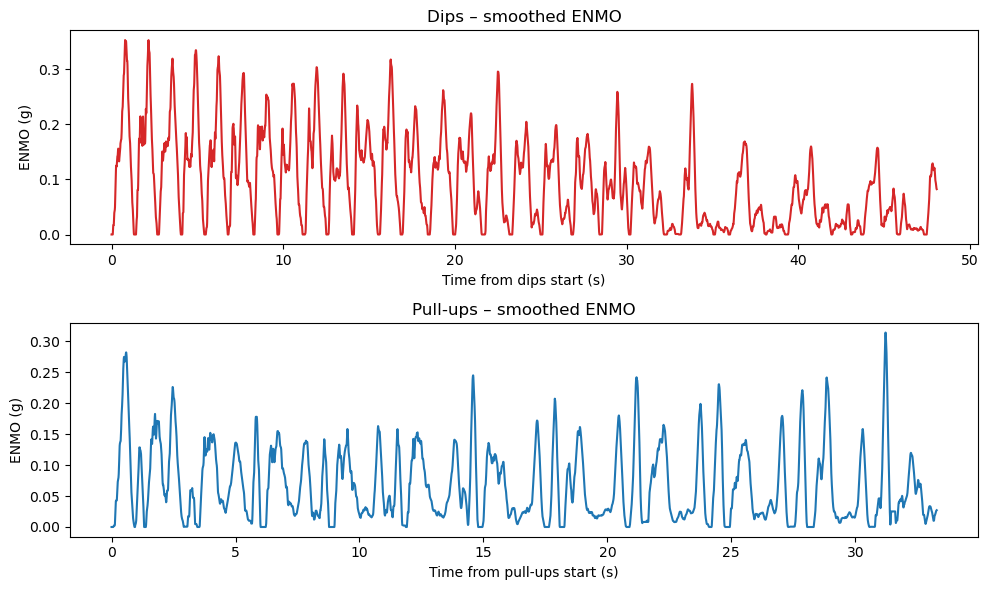

In [12]:
# ======================================
# 7. Visualise smoothed ENMO per exercise
# ======================================

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=False)

axes[0].plot(df_dips["t"] - df_dips["t"].iloc[0],
             df_dips["ENMO_smooth"], color="tab:red")
axes[0].set_title("Dips – smoothed ENMO")
axes[0].set_ylabel("ENMO (g)")
axes[0].set_xlabel("Time from dips start (s)")

axes[1].plot(df_pu["t"] - df_pu["t"].iloc[0],
             df_pu["ENMO_smooth"], color="tab:blue")
axes[1].set_title("Pull-ups – smoothed ENMO")
axes[1].set_ylabel("ENMO (g)")
axes[1].set_xlabel("Time from pull-ups start (s)")

plt.tight_layout()
plt.show()

In [13]:
# # ============================================
# # 8. Generic repetition detection per exercise
# # ============================================
def detect_repetitions(
    df: pd.DataFrame,
    fs: float,
    exercise: str,
    min_interval_s: float,
    percentile: float,
    plot: bool = True,
    mark_fatigue_peaks: bool = True,
) -> pd.DataFrame:
    """
    Detect repetitions on ENMO_smooth using peak detection.

    Returns a DataFrame with:
        - exercise
        - rep_index
        - t_peak_s (relative to start of exercise window)
        - amplitude_g
        - rep_duration_s
        - cadence_rpm

    If mark_fatigue_peaks=True, additional smaller local maxima
    (below the main threshold) are highlighted on the plot but NOT
    counted as full repetitions.
    """

    # Time axis relative to the beginning of the exercise window
    t0 = df["t"].iloc[0]
    t = df["t"].values - t0
    signal = df["ENMO_smooth"].values

    # ---------- 1) Main reps: peaks above adaptive threshold ----------
    thr = np.percentile(signal, percentile)
    min_distance = int(min_interval_s * fs)

    peaks, properties = find_peaks(
        signal,
        height=thr,
        distance=min_distance,
    )

    if len(peaks) == 0:
        print(f"[{exercise}] No peaks detected – check parameters.")
        return pd.DataFrame()

    t_peaks = t[peaks]
    amp_peaks = properties["peak_heights"]

    rep_indices = np.arange(1, len(peaks) + 1)

    rep_durations = np.full_like(t_peaks, np.nan, dtype=float)
    cadence_rpm = np.full_like(t_peaks, np.nan, dtype=float)

    if len(t_peaks) > 1:
        intervals = np.diff(t_peaks)
        rep_durations[1:] = intervals
        cadence_rpm[1:] = 60.0 / intervals

    reps_df = pd.DataFrame(
        {
            "exercise": exercise,
            "rep_index": rep_indices,
            "t_peak_s": t_peaks,
            "amplitude_g": amp_peaks,
            "rep_duration_s": rep_durations,
            "cadence_rpm": cadence_rpm,
        }
    )

    # ---------- 2) Extra smaller peaks (fatigue movements) ----------
        # ---------- 2) Extra smaller peaks (fatigue movements) ----------
    fatigue_t = None
    fatigue_amp = None

    if mark_fatigue_peaks:
        # seuil plus bas pour détecter de petits pics
        low_thr = np.percentile(signal, 50)

        all_peaks, props_all = find_peaks(
            signal,
            height=low_thr,
            distance=int(min_interval_s * fs * 0.7),
        )

        all_t = t[all_peaks]
        all_amp = props_all["peak_heights"]

        # 1) garder seulement ceux qui NE sont PAS déjà des grosses reps
        mask_not_main = ~np.isin(all_peaks, peaks)

        # 2) garder seulement les pics situés en FIN de série
        #    (par ex. dernier tiers du temps)
        late_start = 0.66 * t[-1]   # début de la zone "fatigue"
        mask_late_time = all_t >= late_start

        # 3) garder seulement les pics PLUS PETITS que le seuil principal
        mask_below_main_thr = all_amp < thr

        # masque combiné
        mask_fatigue = mask_not_main & mask_late_time & mask_below_main_thr

        fatigue_t = all_t[mask_fatigue]
        fatigue_amp = all_amp[mask_fatigue]


    # ---------- 3) Plot ----------
    if plot:
        fig, ax = plt.subplots(figsize=(10, 3))

        ax.plot(t, signal, label="ENMO_smooth")

        # principaux pics = vraies répétitions
        ax.plot(t_peaks, amp_peaks, "ro", label="Detected reps")

        # petits pics = mouvements de fatigue (visuels uniquement)
        if mark_fatigue_peaks and fatigue_t is not None and len(fatigue_t) > 0:
            ax.plot(fatigue_t, fatigue_amp, "x", color="orange",
                    label="Small peaks (fatigue)")

        ax.axhline(thr, color="grey", linestyle="--",
                   label=f"{percentile}th percentile")

        ax.set_xlabel("Time from start (s)")
        ax.set_ylabel("ENMO (g)")
        ax.set_title(f"{exercise} – repetition detection on ENMO_smooth")
        ax.legend(loc="upper right")
        plt.tight_layout()
        plt.show()

    return reps_df


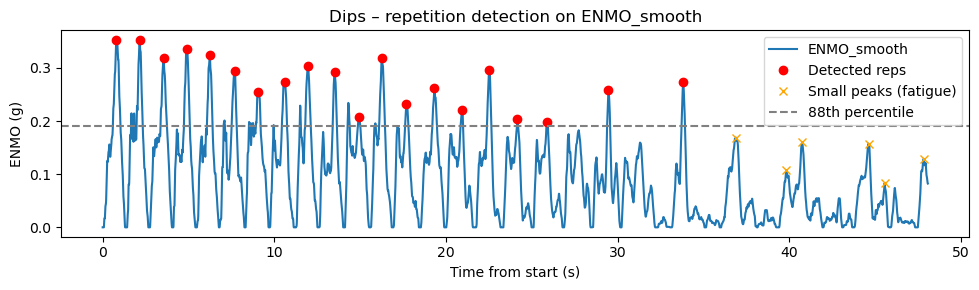

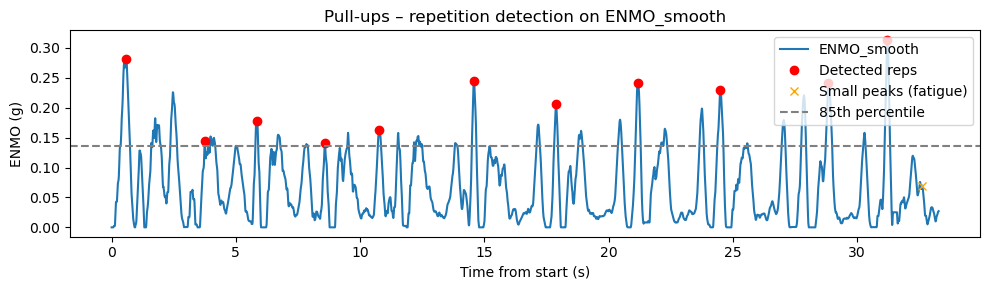

Dips – detected reps: 20
Pull-ups – detected reps: 11


In [14]:
# ==========================================
# 9. Run repetition detection for each exercise
# ==========================================

reps_dips = detect_repetitions(
    df=df_dips,
    fs=fs,
    exercise="Dips",
    min_interval_s=EXERCISE_PARAMS["Dips"]["min_interval_s"],
    percentile=EXERCISE_PARAMS["Dips"]["percentile"],
    plot=True,
)

reps_pu = detect_repetitions(
    df=df_pu,
    fs=fs,
    exercise="Pull-ups",
    min_interval_s=EXERCISE_PARAMS["Pull-ups"]["min_interval_s"],
    percentile=EXERCISE_PARAMS["Pull-ups"]["percentile"],
    plot=True,
)

print("Dips – detected reps:", len(reps_dips))
print("Pull-ups – detected reps:", len(reps_pu))


In [15]:
# ==========================================
# 10. Global summary per exercise
# ==========================================

def summarise_exercise(reps: pd.DataFrame, label: str) -> None:
    n_reps = len(reps)
    if n_reps == 0:
        print(label, ": no repetitions detected.")
        return

    duration_s = reps["t_peak_s"].max() - reps["t_peak_s"].min()

    rep_dur = reps["rep_duration_s"].dropna()
    cad = reps["cadence_rpm"].dropna()
    amp = reps["amplitude_g"].dropna()

    print(f"=== {label} ===")
    print(f"Total repetitions: {n_reps}")
    print(f"Duration between first and last rep: {duration_s:.1f} s")
    if len(rep_dur) > 0:
        print(f"Mean rep duration: {rep_dur.mean():.2f} s (std {rep_dur.std():.2f})")
    if len(cad) > 0:
        print(f"Mean cadence:      {cad.mean():.1f} reps/min (std {cad.std():.1f})")
    print(f"Mean peak ENMO:    {amp.mean():.3f} g (std {amp.std():.3f})")


summarise_exercise(reps_dips, "Dips")
summarise_exercise(reps_pu, "Pull-ups")


=== Dips ===
Total repetitions: 20
Duration between first and last rep: 33.0 s
Mean rep duration: 1.74 s (std 0.80)
Mean cadence:      38.2 reps/min (std 8.8)
Mean peak ENMO:    0.279 g (std 0.048)
=== Pull-ups ===
Total repetitions: 11
Duration between first and last rep: 30.6 s
Mean rep duration: 3.06 s (std 0.73)
Mean cadence:      20.6 reps/min (std 5.1)
Mean peak ENMO:    0.217 g (std 0.056)


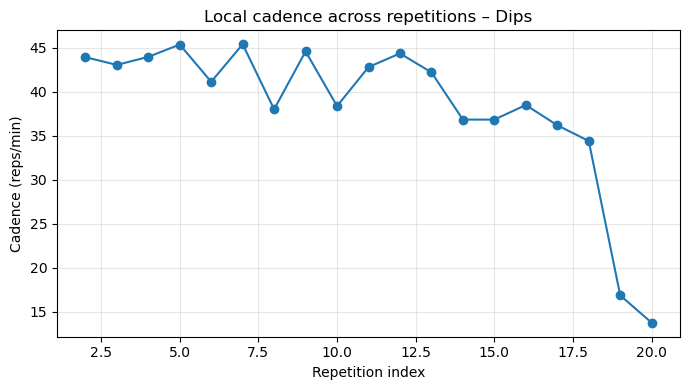

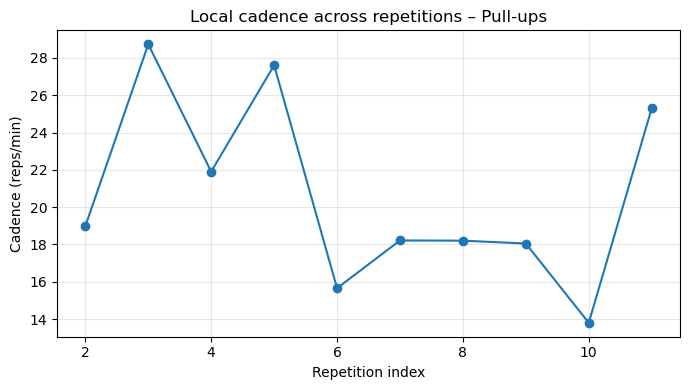

In [16]:
# ========================================================
# 11. Visualise local cadence across repetitions
# ========================================================

def plot_cadence(reps: pd.DataFrame, exercise: str):
    plt.figure(figsize=(7, 4))
    plt.plot(reps["rep_index"], reps["cadence_rpm"],
             marker="o", linestyle="-")
    plt.xlabel("Repetition index")
    plt.ylabel("Cadence (reps/min)")
    plt.title(f"Local cadence across repetitions – {exercise}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_cadence(reps_dips, "Dips")
plot_cadence(reps_pu, "Pull-ups")


In [17]:
# ==========================================================
# 12. Early / middle / late phases for each exercise
# ==========================================================

def add_phase_column(reps_df: pd.DataFrame) -> pd.DataFrame:
    """
    Add a 'phase' column: 'early', 'middle', 'late'
    based on rep_index tertiles.
    """
    n = len(reps_df)
    if n < 3:
        reps_df["phase"] = "all"
        return reps_df.copy()

    tertiles = np.linspace(1, n + 1, 4, dtype=int)
    bounds = list(zip(tertiles[:-1], tertiles[1:]))

    labels = ["early", "middle", "late"]
    phase = []

    for idx in reps_df["rep_index"]:
        if idx >= bounds[0][0] and idx < bounds[0][1]:
            phase.append("early")
        elif idx >= bounds[1][0] and idx < bounds[1][1]:
            phase.append("middle")
        else:
            phase.append("late")

    out = reps_df.copy()
    out["phase"] = phase
    return out


reps_dips_phase = add_phase_column(reps_dips)
reps_pu_phase   = add_phase_column(reps_pu)

def phase_summary(reps_phase: pd.DataFrame, exercise: str) -> pd.DataFrame:
    summary = (
        reps_phase
        .groupby("phase")
        .agg(
            n_reps=("rep_index", "count"),
            mean_rep_duration=("rep_duration_s", "mean"),
            mean_cadence=("cadence_rpm", "mean"),
            mean_amplitude=("amplitude_g", "mean"),
        )
        .round(2)
        .reset_index()
    )
    summary["exercise"] = exercise
    return summary


summary_dips = phase_summary(reps_dips_phase, "Dips")
summary_pu   = phase_summary(reps_pu_phase, "Pull-ups")

phase_summary_all = pd.concat([summary_dips, summary_pu], ignore_index=True)
phase_summary_all


,phase,n_reps,mean_rep_duration,mean_cadence,mean_amplitude,exercise
0,early,6,1.38,43.48,0.33,Dips
1,late,7,2.31,30.48,0.24,Dips
2,middle,7,1.43,42.24,0.27,Dips
3,early,3,2.62,23.86,0.20,Pull-ups
4,late,4,3.34,18.84,0.26,Pull-ups
5,middle,4,3.01,20.85,0.19,Pull-ups


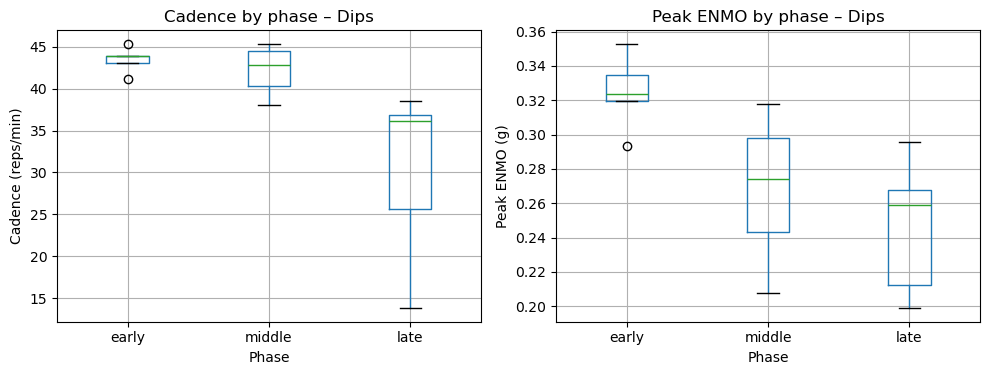

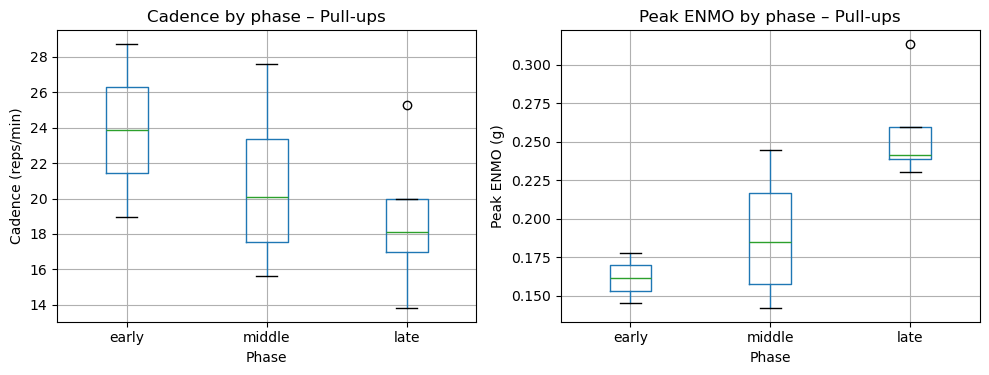

In [18]:
# ==================================================
# 13. Boxplots of cadence & amplitude by phase
# ==================================================

def boxplots_by_phase(reps_phase: pd.DataFrame, exercise: str):
    valid = reps_phase.dropna(subset=["cadence_rpm", "amplitude_g"]).copy()

    # impose phase order
    phase_order = ["early", "middle", "late"]
    valid["phase"] = pd.Categorical(valid["phase"],
                                    categories=phase_order,
                                    ordered=True)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    valid.boxplot(column="cadence_rpm", by="phase", ax=axes[0])
    axes[0].set_title(f"Cadence by phase – {exercise}")
    axes[0].set_xlabel("Phase")
    axes[0].set_ylabel("Cadence (reps/min)")

    valid.boxplot(column="amplitude_g", by="phase", ax=axes[1])
    axes[1].set_title(f"Peak ENMO by phase – {exercise}")
    axes[1].set_xlabel("Phase")
    axes[1].set_ylabel("Peak ENMO (g)")

    plt.suptitle("")
    plt.tight_layout()
    plt.show()


boxplots_by_phase(reps_dips_phase, "Dips")
boxplots_by_phase(reps_pu_phase, "Pull-ups")


In [22]:
# ================================================
# 14. Compute ENMO-integrated "load" per repetition
# ================================================

import numpy as np
import pandas as pd

def compute_rep_loads(df_exercise: pd.DataFrame,
                      reps_exercise: pd.DataFrame) -> np.ndarray:
    """
    Compute ENMO-integrated load for each repetition of one exercise.

    Parameters
    ----------
    df_exercise : DataFrame
        Contains columns 't' (absolute time in seconds) and 'ENMO_smooth'.
        Should correspond to one exercise window (only dips OR only pull-ups).
    reps_exercise : DataFrame
        Contains at least column 't_peak_s' (time of peaks relative to
        the start of the exercise window), one row per repetition.

    Returns
    -------
    loads : np.ndarray
        Array of length n_reps with the integrated ENMO for each repetition.
    """
    # Time axis relative to the beginning of the exercise window
    t_abs = df_exercise["t"].values
    t_rel = t_abs - t_abs[0]
    enmo = df_exercise["ENMO_smooth"].values

    peaks = reps_exercise["t_peak_s"].values
    n = len(peaks)
    loads = []

    if n == 0:
        return np.array([])

    # Define repetition boundaries as midpoints between consecutive peaks
    for i in range(n):
        if i == 0:
            start = 0.0
        else:
            start = 0.5 * (peaks[i - 1] + peaks[i])

        if i == n - 1:
            end = t_rel[-1]
        else:
            end = 0.5 * (peaks[i] + peaks[i + 1])

        mask = (t_rel >= start) & (t_rel < end)
        if mask.sum() > 1:
            load_i = np.trapz(enmo[mask], t_rel[mask])
        else:
            load_i = 0.0  # safety fallback

        loads.append(load_i)

    return np.array(loads)


# Compute loads and attach them to the per-repetition tables with phases
reps_dips_phase = reps_dips_phase.copy()
reps_pu_phase   = reps_pu_phase.copy()

reps_dips_phase["enmo_load"] = compute_rep_loads(df_dips, reps_dips_phase)
reps_pu_phase["enmo_load"]   = compute_rep_loads(df_pu,   reps_pu_phase)

reps_dips_phase.head(), reps_pu_phase.head()



C:\Users\Hp\AppData\Local\Temp\ipykernel_19280\3342805909.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  load_i = np.trapz(enmo[mask], t_rel[mask])


(  exercise  rep_index  t_peak_s  amplitude_g  rep_duration_s  cadence_rpm  \
 0     Dips          1     0.790     0.353105             NaN          NaN   
 1     Dips          2     2.156     0.352981           1.366    43.923865   
 2     Dips          3     3.550     0.319373           1.394    43.041607   
 3     Dips          4     4.915     0.334727           1.365    43.956044   
 4     Dips          5     6.238     0.323680           1.323    45.351474   
 
    phase  enmo_load  
 0  early   0.210489  
 1  early   0.211364  
 2  early   0.205514  
 3  early   0.198053  
 4  early   0.194898  ,
    exercise  rep_index  t_peak_s  amplitude_g  rep_duration_s  cadence_rpm  \
 0  Pull-ups          1     0.590     0.281847             NaN          NaN   
 1  Pull-ups          2     3.751     0.145026           3.161    18.981335   
 2  Pull-ups          3     5.839     0.177830           2.088    28.735632   
 3  Pull-ups          4     8.578     0.141595           2.739    21.905805

In [23]:
# ============================================================
# 15. Summarise movement load: early+middle vs late only
# ============================================================

def summarise_movement_load_em_vs_late(reps_phase: pd.DataFrame,
                                       exercise: str) -> dict:
    """
    Summarise ENMO-integrated load for one exercise.

    - load_early_middle: sum of ENMO load for early + middle repetitions
    - load_late:         sum of ENMO load for late repetitions only
    """
    df = reps_phase.copy()

    # Early + middle = "good quality" reps
    mask_em = df["phase"].isin(["early", "middle"])
    load_em = df.loc[mask_em, "enmo_load"].sum()

    # Late only = fatigue reps
    mask_late = df["phase"] == "late"
    load_late = df.loc[mask_late, "enmo_load"].sum()

    return {
        "exercise": exercise,
        "load_early_middle": load_em,
        "load_late": load_late,
    }


load_dips = summarise_movement_load_em_vs_late(reps_dips_phase, "Dips")
load_pu   = summarise_movement_load_em_vs_late(reps_pu_phase,   "Pull-ups")

load_summary = pd.DataFrame([load_dips, load_pu])
load_summary



,exercise,load_early_middle,load_late
0,Dips,2.505035,1.976059
1,Pull-ups,1.398317,0.856136
